In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
path = '/nfs/team283/aa16/'
from matplotlib import rcParams
import seaborn as sns
# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
import pickle

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Load metadata:

In [2]:
rSlides = np.array(('00MU', '00MV', '00MV-2')) # slide we want to look at
AOI_type = np.array(('HOPXpos', 'EOMESpos', 'Residual', 'Ring', 'Geometric'))
Radial_positions = np.array((1,2,3))

# Let's load the data and metadata from our Nanostring experiment:

counts = pd.read_table('/nfs/team283/aa16/KR_NAS/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
counts = counts[np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288]
metadata = pd.read_csv('/nfs/team283/aa16/KR_NAS/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table('/nfs/team283/aa16/KR_NAS/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))] 

# Let's load the Polioudakis 2019 data as a reference, as well as the cell type specific marker genes:

polioudakis = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/cellStateMatrix.csv')
markers = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/clusterMarkers.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

# Choose the top N markers only:

N = 333
columnNames = np.unique(markers['cluster'])
topN_markers = pd.DataFrame(index=range(N), columns=columnNames)
for i in range(len(columnNames)):
    topN_temp = np.array(markers[markers['cluster'] == columnNames[i]].iloc[0:N,].iloc[:,0])
    topN_markers[columnNames[i]] = [topN_temp[i].split('.')[0] for i in range(len(topN_temp))]
topN_array = np.array(topN_markers).flatten()  

subset_rois = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in Radial_positions and metadata['AOI_type'][i] in AOI_type for i in range(len(metadata['slide']))]
relevantIDs = metadata['Sample_ID'][subset_rois]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_rois]
counts_subset = counts.loc[:,relevantSangerIDs]
subset_genes = [counts_subset.index[i] in topN_array for i in range(len(counts_subset.index))]
counts_subset = counts_subset.iloc[subset_genes,:]
polioudakis_subset = polioudakis.reindex(np.array(counts_subset.index))

polioudakis_subset = polioudakis.reindex(np.array(counts_subset.index))

metadata_subset = metadata.reindex(counts_subset.keys())

These are our three models:

In [3]:
# -*- coding: utf-8 -*-
"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood 
    - similar to LocationModelV7_V4_V4"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from pymc3.distributions.dist_math import bound, logpow, factln, binomln #betaln, logpow, random_choice

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelNB4V7_V4_V4(Pymc3LocModel):
    r"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood
         - similar to LocationModelNB2V7_V4_V4
         pymc3 NB parametrisation but overdisp priors as described here https://statmodeling.stat.columbia.edu/2018/04/03/justify-my-love/
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - what is the number of cells you expect per location?
                                factors_per_spot - what is the number of cell types 
                                                        / number of factors expressed per location?
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in both prior
                                                        expressed as a mean/var ratio, numbers < 1 mean high uncertainty
    :param phi_hyp_prior: prior on overdispersion parameter, rate of exponential distribution over phi / theta
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 200000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.001},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1},
        phi_hyp_prior={'mean': 3, 'sd': 1},
        cutoff_poisson = 10
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)

        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior
        self.phi_hyp_prior = phi_hyp_prior
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0).shape)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0))
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(cell_number_prior['cells_per_spot'] \
                                                         / cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(cell_number_prior['factors_per_spot'] \
                                                           / cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # per gene molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed equally between all spots (e.g. background, free-floating RNA)
            self.gene_add_hyp = pm.Gamma('gene_add_hyp', 1, 1, shape=2)
            self.gene_add = pm.Gamma('gene_add', self.gene_add_hyp[0],
                                     self.gene_add_hyp[1], shape=(self.n_genes, 1))
            
            # =====================Gene-specific overdispersion ======================= #
            self.phi_hyp = pm.Gamma('phi_hyp', mu=phi_hyp_prior['mean'], 
                                    sigma=phi_hyp_prior['sd'], shape=(1, 1))
            self.gene_E = pm.Exponential('gene_E', self.phi_hyp, shape=(self.n_genes, 1))
            self.alpha = 1/(self.gene_E.T * self.gene_E.T)
            
            # =====================Expected expression ======================= #
            # expected expression
            self.mu_biol = pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T \
                                    + self.gene_add.T + self.spot_add
            #tt.printing.Print('mu_biol')(self.mu_biol.shape)
    
            # =====================DATA likelihood ======================= #
            # Likelihood (sampling distribution) of observations & add overdispersion via NegativeBinomial / Poisson
#             self.data_target = pm.NegativeBinomial('data_target', mu=self.mu_biol,
#                                                    alpha=1/(self.gene_E.T * self.gene_E.T),
#                                           observed=self.x_data,
#                                           total_size=self.X_data.shape)
            
            self.data_target = pm.DensityDist('data_target', self.logp_NegBinom,
                                             observed = self.x_data)    
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def logp_Poisson(self, value):
        r"""
        Calculate log-probability of Poisson distribution at specified value. 
        Switches to Gamma distribution when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        log_prob = bound(
            logpow(mu, value) - factln(value) - mu,
            mu >= 0, value >= 0)
        # Return zero when mu and value are both zero, return Gamma when mu is large
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.eq(mu, 0) * tt.eq(value, 0),
                         0, log_prob))
    
    def logp_NegBinom(self, value):
        r"""
        Calculate log-probability of NegativeBinomial distribution at specified value.
        Swtiches to Poisson when alpha gets very large, to Gamma when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        alpha = self.alpha
        negbinom = bound(binomln(value + alpha - 1, value)
                         + logpow(mu / (mu + alpha), value)
                         + logpow(alpha / (mu + alpha), alpha),
                         value >= 0, mu > 0, alpha > 0)

        # Return Poisson when alpha gets very large. Return Gamma when mu gets very large.
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.gt(alpha, 1e10),
                         pm.Poisson.dist(mu).logp(value),
                         negbinom)) 
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
    def plot_gene_E(self):
        
        plt.hist((self.samples['post_sample_means']['gene_E'][:,0]), bins = 50)
        plt.xlabel('E_g overdispersion parameter')
        plt.title('E_g overdispersion parameter')
        plt.tight_layout()
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate
        self.mu = (np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add'].T \
        + self.samples['post_sample_means']['spot_add']) #\
       # * self.samples['post_sample_means']['gene_E'] 

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [4]:
mod1 = pickle.load( open( "mod_CellTypeMapping_NegBinom.p", "rb" ) )

In [5]:
# -*- coding: utf-8 -*-
"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood 
    - similar to LocationModelV7_V4_V4"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from pymc3.distributions.dist_math import bound, logpow, factln, binomln #betaln, logpow, random_choice

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelNB4V7_V4_V4(Pymc3LocModel):
    r"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood
         - similar to LocationModelNB2V7_V4_V4
         pymc3 NB parametrisation but overdisp priors as described here https://statmodeling.stat.columbia.edu/2018/04/03/justify-my-love/
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - what is the number of cells you expect per location?
                                factors_per_spot - what is the number of cell types 
                                                        / number of factors expressed per location?
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in both prior
                                                        expressed as a mean/var ratio, numbers < 1 mean high uncertainty
    :param phi_hyp_prior: prior on overdispersion parameter, rate of exponential distribution over phi / theta
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 200000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.001},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1},
        phi_hyp_prior={'mean': 3, 'sd': 1},
        cutoff_poisson = 10
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)

        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior
        self.phi_hyp_prior = phi_hyp_prior
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0).shape)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0))
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(cell_number_prior['cells_per_spot'] \
                                                         / cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(cell_number_prior['factors_per_spot'] \
                                                           / cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # per gene molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed equally between all spots (e.g. background, free-floating RNA)
            self.gene_add_hyp = pm.Gamma('gene_add_hyp', 1, 1, shape=2)
            self.gene_add = pm.Gamma('gene_add', self.gene_add_hyp[0],
                                     self.gene_add_hyp[1], shape=(self.n_genes, 1))
            
            # =====================Gene-specific overdispersion ======================= #
            self.phi_hyp = pm.Gamma('phi_hyp', mu=phi_hyp_prior['mean'], 
                                    sigma=phi_hyp_prior['sd'], shape=(1, 1))
            self.gene_E = pm.Exponential('gene_E', self.phi_hyp, shape=(self.n_genes, 1))
            self.alpha = 1/(self.gene_E.T * self.gene_E.T)
            
            # =====================Expected expression ======================= #
            # expected expression
            self.mu_biol = pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T \
                                    + self.gene_add.T + self.spot_add
            #tt.printing.Print('mu_biol')(self.mu_biol.shape)
    
            # =====================DATA likelihood ======================= #
            # Likelihood (sampling distribution) of observations & add overdispersion via NegativeBinomial / Poisson
#             self.data_target = pm.NegativeBinomial('data_target', mu=self.mu_biol,
#                                                    alpha=1/(self.gene_E.T * self.gene_E.T),
#                                           observed=self.x_data,
#                                           total_size=self.X_data.shape)
            
            self.data_target = pm.DensityDist('data_target', self.logp_Poisson,
                                             observed = self.x_data)    
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def logp_Poisson(self, value):
        r"""
        Calculate log-probability of Poisson distribution at specified value. 
        Switches to Gamma distribution when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        log_prob = bound(
            logpow(mu, value) - factln(value) - mu,
            mu >= 0, value >= 0)
        # Return zero when mu and value are both zero, return Gamma when mu is large
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.eq(mu, 0) * tt.eq(value, 0),
                         0, log_prob))
    
    def logp_NegBinom(self, value):
        r"""
        Calculate log-probability of NegativeBinomial distribution at specified value.
        Swtiches to Poisson when alpha gets very large, to Gamma when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        alpha = self.alpha
        negbinom = bound(binomln(value + alpha - 1, value)
                         + logpow(mu / (mu + alpha), value)
                         + logpow(alpha / (mu + alpha), alpha),
                         value >= 0, mu > 0, alpha > 0)

        # Return Poisson when alpha gets very large. Return Gamma when mu gets very large.
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.gt(alpha, 1e10),
                         pm.Poisson.dist(mu).logp(value),
                         negbinom)) 
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
    def plot_gene_E(self):
        
        plt.hist((self.samples['post_sample_means']['gene_E'][:,0]), bins = 50)
        plt.xlabel('E_g overdispersion parameter')
        plt.title('E_g overdispersion parameter')
        plt.tight_layout()
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate
        self.mu = (np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add'].T \
        + self.samples['post_sample_means']['spot_add']) #\
       # * self.samples['post_sample_means']['gene_E'] 


In [6]:
mod2 = pickle.load( open( "mod_CellTypeMapping_Poisson.p", "rb" ) )

In [7]:
# -*- coding: utf-8 -*-
"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood 
    - similar to LocationModelV7_V4_V4"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from pymc3.distributions.dist_math import bound, logpow, factln, binomln #betaln, logpow, random_choice

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelNB4V7_V4_V4(Pymc3LocModel):
    r"""LocationModelNB4V7_V4_V4 Cell location model with E_g overdispersion & NB likelihood
         - similar to LocationModelNB2V7_V4_V4
         pymc3 NB parametrisation but overdisp priors as described here https://statmodeling.stat.columbia.edu/2018/04/03/justify-my-love/
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - what is the number of cells you expect per location?
                                factors_per_spot - what is the number of cell types 
                                                        / number of factors expressed per location?
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in both prior
                                                        expressed as a mean/var ratio, numbers < 1 mean high uncertainty
    :param phi_hyp_prior: prior on overdispersion parameter, rate of exponential distribution over phi / theta
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        Y_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 100000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.001},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1},
        phi_hyp_prior={'mean': 3, 'sd': 1},
        cutoff_poisson = 10
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)
        
        self.Y_data = Y_data
        self.n_npro = Y_data.shape[1]
        self.y_data = theano.shared(Y_data.astype(self.data_type))
        self.n_rois = Y_data.shape[0]
        self.l_r = np.array([np.sum(X_data[i,:]) for i in range(self.n_rois)]).reshape(self.n_rois,1)*10**(-5)
        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior
        self.phi_hyp_prior = phi_hyp_prior
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            
            ### Negative Probe Counts ###
            self.b_n_hyper = pm.Gamma('b_n_hyper', alpha = np.array((3,1)), beta = np.array((1,1)), shape = 2)
            self.b_n = pm.Gamma('b_n', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_npro))
            self.y_rn = self.b_n*self.l_r
            
            tt.printing.Print('y_rn')(self.y_rn.shape)
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0).shape)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0))
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(cell_number_prior['cells_per_spot'] \
                                                         / cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(cell_number_prior['factors_per_spot'] \
                                                           / cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # In GeoMX this is background/non-specific binding
            
            # Background for gene probes, drawn from the same distribution as negative probes:
            self.gene_add = pm.Gamma('gene_add', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_genes))
            
            # =====================Expected expression ======================= #
            #expected expression
            self.mu_biol = tt.concatenate([self.y_rn, pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T \
                                    + self.gene_add * self.l_r + self.spot_add], axis = 1)
            tt.printing.Print('mu_biol')(self.mu_biol.shape)
            
            self.data_target = pm.DensityDist('data_target', self.logp_Poisson,
                                             observed = tt.concatenate([self.y_data, self.x_data], axis = 1))    
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def logp_Poisson(self, value):
        r"""
        Calculate log-probability of Poisson distribution at specified value. 
        Switches to Gamma distribution when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        log_prob = bound(
            logpow(mu, value) - factln(value) - mu,
            mu >= 0, value >= 0)
        # Return zero when mu and value are both zero, return Gamma when mu is large
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.eq(mu, 0) * tt.eq(value, 0),
                         0, log_prob))
    
    def logp_NegBinom(self, value):
        r"""
        Calculate log-probability of NegativeBinomial distribution at specified value.
        Swtiches to Poisson when alpha gets very large, to Gamma when mu gets very large ( > 1000)
        Parameters
        ----------
        value: numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        mu = self.mu_biol
        alpha = self.alpha
        negbinom = bound(binomln(value + alpha - 1, value)
                         + logpow(mu / (mu + alpha), value)
                         + logpow(alpha / (mu + alpha), alpha),
                         value >= 0, mu > 0, alpha > 0)

        # Return Poisson when alpha gets very large. Return Gamma when mu gets very large.
        return tt.switch(tt.gt(mu,1e3),
                         pm.Gamma.dist(mu = mu, sd = tt.sqrt(mu)).logp(value),
                         tt.switch(tt.gt(alpha, 1e10),
                         pm.Poisson.dist(mu).logp(value),
                         negbinom)) 
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
    def plot_gene_E(self):
        
        plt.hist((self.samples['post_sample_means']['gene_E'][:,0]), bins = 50)
        plt.xlabel('E_g overdispersion parameter')
        plt.title('E_g overdispersion parameter')
        plt.tight_layout()
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate
        self.mu = (np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add']*self.l_r \
        + self.samples['post_sample_means']['spot_add']) #\
       # * self.samples['post_sample_means']['gene_E'] 


In [8]:
mod3 = pickle.load(open( "mod_CellTypeMapping_Poisson_Adapted.p", "rb" ))

Now we make comparative plots of the cell type mapping resulting from those three models:

In [9]:
subset = np.where(np.array([metadata_subset['AOI_type'][i] == 'Geometric' and metadata_subset['slide'][i] == '00MU' for i in range(len(metadata_subset['AOI_type']))]))[0]
order = subset[np.argsort(metadata_subset['VCDepth'].iloc[subset])]

<Figure size 432x288 with 0 Axes>

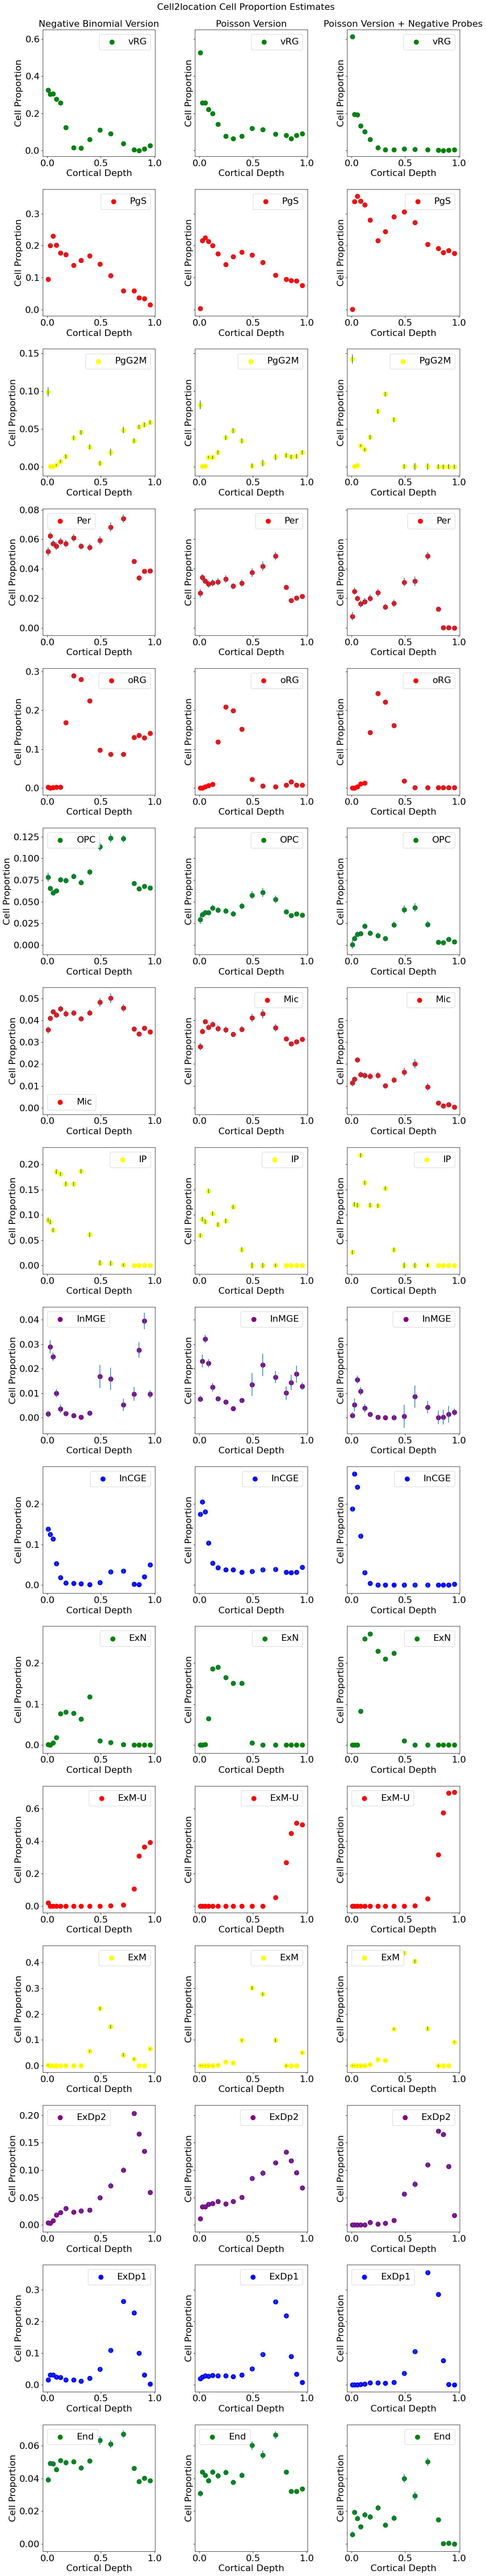

In [12]:
from matplotlib.pyplot import figure

# Set figure parameters:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results:
results1 = mod1.spot_factors_df
results_normed1 = np.array(results1)[order,:]
results_normed1 = (results_normed1.T/[sum(results_normed1[i,]) for i in range(len(results_normed1[:,1]))]).T

results_sd1 = mod1.spot_factors_sd
results_sd1_normed = np.array(results_sd1)[order,:]
results_sd1_normed = 2*(results_sd1_normed.T/[sum(results1.iloc[order,:].iloc[i,:]) for i in range(len(results1.iloc[order,1]))]).T

results2 = mod2.spot_factors_df
results_normed2 = np.array(results2)[order,:]
results_normed2 = (results_normed2.T/[sum(results_normed2[i,]) for i in range(len(results_normed2[:,1]))]).T

results_sd2 = mod2.spot_factors_sd
results_sd2_normed = np.array(results_sd2)[order,:]
results_sd2_normed = 2*(results_sd2_normed.T/[sum(results2.iloc[order,:].iloc[i,:]) for i in range(len(results2.iloc[order,1]))]).T

results3 = mod3.spot_factors_df
results_normed3 = np.array(results3)[order,:]
results_normed3 = (results_normed3.T/[sum(results_normed3[i,]) for i in range(len(results_normed3[:,1]))]).T

results_sd3 = mod3.spot_factors_sd
results_sd3_normed = np.array(results_sd3)[order,:]
results_sd3_normed = 2*(results_sd3_normed.T/[sum(results3.iloc[order,:].iloc[i,:]) for i in range(len(results3.iloc[order,1]))]).T


figure(num=None, )
celltypes = polioudakis.columns
fig, ax = plt.subplots(len(celltypes),3, sharey='row',
figsize=(15,len(celltypes)*5), dpi=80, facecolor='w', edgecolor='k')

polynomial_order = 6

cellColours = np.array(('green', 'blue', 'purple', 'yellow', 'red', 'green', 'blue', 'purple', 'yellow', 'red', 'green', 'red', 'red', 'yellow', 'red', 'green', 'blue', 'purple', 'yellow', 'red'))

for i in range(len(celltypes)):
    x = sample_info['x'][subset_rois][order]
    y = results_normed1[:,celltypes == celltypes[i]][:,0]
    c = results_sd1_normed[:, celltypes == celltypes[i]][:,0]
    ax[15-i,0].scatter(x, y, label = celltypes[i], c = cellColours[i], s = 100)
    ax[15-i,0].errorbar(x,y,yerr=c, linestyle="None")
    ax[15-i,0].set_xlabel('Cortical Depth')
    ax[15-i,0].set_ylabel('Cell Proportion')
    ax[15-i,0].legend()
    if i == 0:
        ax[i,0].set_title('Negative Binomial Version')
    x = sample_info['x'][subset_rois][order]
    y = results_normed2[:,celltypes == celltypes[i]][:,0]
    ax[15-i,1].scatter(x, y, label = celltypes[i], c = cellColours[i], s = 100)
    ax[15-i,1].errorbar(x,y,yerr=c, linestyle="None")
    ax[15-i,1].set_xlabel('Cortical Depth')
    ax[15-i,1].set_ylabel('Cell Proportion')
    ax[15-i,1].legend()
    if i == 0:
        ax[i,1].set_title('Poisson Version')
    x = sample_info['x'][subset_rois][order]
    y = results_normed3[:,celltypes == celltypes[i]][:,0]
    ax[15-i,2].scatter(x, y, label = celltypes[i], c = cellColours[i], s = 100)
    ax[15-i,2].errorbar(x,y,yerr=c, linestyle="None")
    ax[15-i,2].set_xlabel('Cortical Depth')
    ax[15-i,2].set_ylabel('Cell Proportion')
    ax[15-i,2].legend()
    if i == 0:
        ax[i,2].set_title('Poisson Version + Negative Probes')
fig.suptitle('Cell2location Cell Proportion Estimates')
plt.tight_layout()
fig.subplots_adjust(top=0.97)
plt.savefig('/nfs/team283/aa16/KR_NAS/notebooks/cellproportionComparison.pdf')
plt.show()

In [ ]:
mod2.spot_factors

In [ ]:
results_sd1 = mod2.spot_factors_sd
results_sd1_normed = np.array(results_sd1)[order,:]
results_sd1_normed = (results_sd1_normed.T/[sum(results_normed1[i,]) for i in range(len(results_normed1[:,1]))]).T

In [ ]:
mod1.spot_factors_df